In [51]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
import glob
import json
import os
import statsmodels.api as st
from statsmodels.discrete.discrete_model import MNLogit
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Use ./aholovenko_data_preprocessing.ipynb to generate processed data.

# Importing data

In [53]:
df = pd.read_pickle('../fairman2019marijuana_dataframe.pickle')
df.shape

(293581, 6)

In [54]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE,MINAGE
0,6,0,0,1,8,16
1,6,2,1,6,3,14
2,6,1,1,0,6,13
3,6,5,0,6,1,0
4,6,3,0,6,8,15


In [55]:
df.dtypes

YEAR      int32
CLASS     int32
SEX       int32
RACE      int32
AGE       int32
MINAGE    int32
dtype: object

# Reproduce Figure 1

Figure 1: Percent of youth aged 12–21-years whose first drug use was marijuana, cigarettes, alcohol, other tobacco, other drugs, or no drug use by demographic characteristics and survey year. 

Abbreviations: American Indian/Alaska Native (AI/AN); Native Hawaiian and other Pacific Islander (NHOPI).

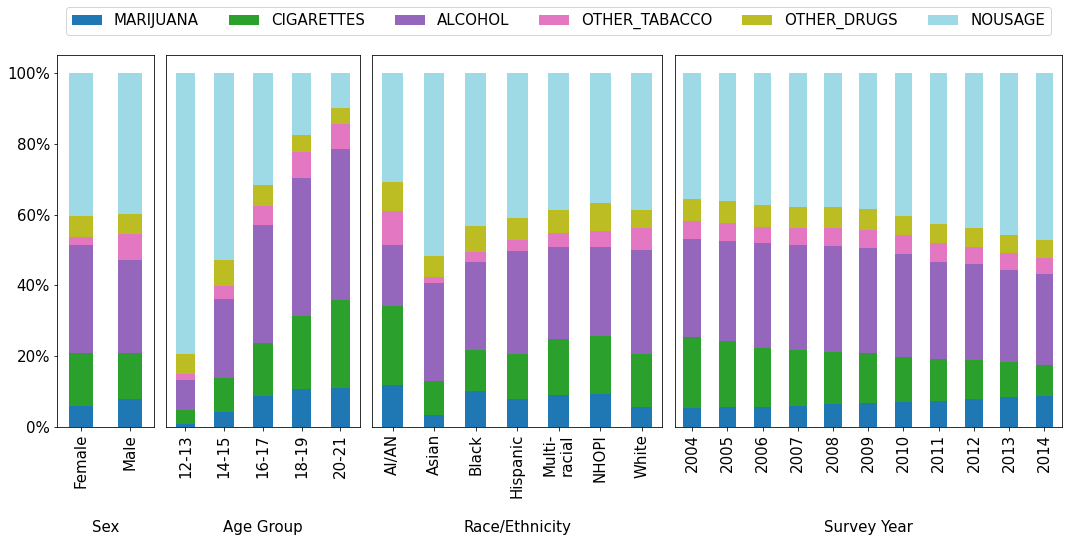

In [76]:


def plot_figure(df_):
    df = df_.copy()
    INPUT_FILES = [
        'fairman2019marijuana/data/32722-0001-Data.tsv', 'fairman2019marijuana/data/23782-0001-Data.tsv', 'fairman2019marijuana/data/04596-0001-Data.tsv',
        'fairman2019marijuana/data/26701-0001-Data.tsv', 'fairman2019marijuana/data/29621-0001-Data.tsv', 'fairman2019marijuana/data/36361-0001-Data.tsv',
        'fairman2019marijuana/data/35509-0001-Data.tsv', 'fairman2019marijuana/data/04373-0001-Data.tsv', 'fairman2019marijuana/data/21240-0001-Data.tsv',
        'fairman2019marijuana/data/34481-0001-Data.tsv', 'fairman2019marijuana/data/34933-0001-Data.tsv'
    ]
    FILE_YEAR_MAP = {f: i for i, f in enumerate(sorted([os.path.basename(f) for f in INPUT_FILES]))}
    AGE_MAP = {i: i + 12 for i in range(0, 10)}
    AGE_GROUP_MAP = {
        0: '12-13', 1: '12-13', 2: '14-15', 3: '14-15', 4: '16-17', 5: '16-17', 6: '18-19', 7: '18-19',
        8: '20-21', 9: '20-21'
    }
    YEAR_MAP = {2004 + i: i for i in range(len(FILE_YEAR_MAP))}
    SEX_MAP = {'Male': 0, 'Female': 1}
    RACE_MAP = {'White': 0, 'Black': 1, 'AI/AN': 2, 'NHOPI': 3, 'Asian': 4, 'Multi-\nracial': 5, 'Hispanic': 6}
    CLASSES_PRETTY = {
        'CIGARETTES': 0, 'ALCOHOL': 1, 'MARIJUANA': 2, 'OTHER_TABACCO': 3, 'OTHER_DRUGS': 4, 'NOUSAGE': 5
    }
    df['AGE_GROUP'] = df['AGE'].map(AGE_GROUP_MAP)
    df['SEX'] = df['SEX'].map(dict(zip(SEX_MAP.values(), SEX_MAP.keys())))
    df['RACE'] = df['RACE'].map(dict(zip(RACE_MAP.values(), RACE_MAP.keys())))
    df['YEAR'] = df['YEAR'].map(dict(zip(YEAR_MAP.values(), YEAR_MAP.keys())))
    df['CLASS'] = df['CLASS'].map(dict(zip(CLASSES_PRETTY.values(), CLASSES_PRETTY.keys())))
    cols = ['MARIJUANA', 'CIGARETTES', 'ALCOHOL', 'OTHER_TABACCO', 'OTHER_DRUGS', 'NOUSAGE']
    prop_sex = pd.crosstab(index=df['SEX'], columns=df['CLASS'], normalize="index") * 100
    prop_race = pd.crosstab(index=df['RACE'], columns=df['CLASS'], normalize="index") * 100
    prop_age = pd.crosstab(index=df['AGE_GROUP'], columns=df['CLASS'], normalize="index") * 100
    prop_year = pd.crosstab(index=df['YEAR'], columns=df['CLASS'], normalize="index") * 100
    figure, axis = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 2, 3, 4]})
    figure.set_size_inches(15, 6, forward=True)
    figure.tight_layout()
    prop_sex[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[0], legend=None, xlabel='Sex')
    prop_age[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[1], legend=None, xlabel='Age Group')
    prop_race[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[2], legend=None,
                         xlabel='Race/Ethnicity')
    prop_year[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[3], legend=None,
                             xlabel='Survey Year')
    axis[0].yaxis.set_major_formatter('{x:1.0f}%')
    axis[1].set_yticks([])
    axis[2].set_yticks([])
    axis[3].set_yticks([])
    axis[0].xaxis.set_label_coords(.5, -.25)
    axis[1].xaxis.set_label_coords(.5, -.25)
    axis[2].xaxis.set_label_coords(.5, -.25)
    axis[3].xaxis.set_label_coords(.5, -.25)
    plt.subplots_adjust(wspace=0.05)
    plt.legend(loc='upper center', bbox_to_anchor=(-0.30, 1.15), ncol=6)
    plt.savefig('fairman2019marijuana_figure_1.png',
                facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.5)
    plt.show()

    
plot_figure(df)

# Reproduce Table 1

Table 1: Demographic and survey characteristics associated with using marijuana as the first drug used relative to no drug use, using cigarettes first, or using alcohol first (n=275,559), adjusted relative risk ratios (aRRR).

In [46]:
class_mapping = {
    'MARIJUANA': 0,
    'ALCOHOL': 1,
    'CIGARETTES': 2,
    'NO_DRUG_USE': 3,
    'OTHER_TABACCO': 4,
    'OTHER_DRUGS': 5
}

In [47]:
data = df.copy()
data['CLASS'] = data.CLASS.map(class_mapping)
data['AGE'] = data.AGE.astype(np.int32)
data['YEAR'] = data.YEAR.astype(np.int32)
data.dtypes

YEAR           int32
CLASS        float64
SEX           object
RACE          object
AGE            int32
MINAGE         int32
AGE_GROUP     object
dtype: object

In [48]:
data.shape

(293581, 7)

In [49]:
data.head()

,YEAR,CLASS,SEX,RACE,AGE,MINAGE,AGE_GROUP
0,2010,2.0,Male,Black,8,16,20-21
1,2010,0.0,Female,Hispanic,3,14,14-15
2,2010,1.0,Female,White,6,13,18-19
3,2010,NaN,Male,Hispanic,1,0,12-13
4,2010,4.0,Male,Hispanic,8,15,20-21


In [50]:
model = sm.MNLogit.from_formula(
    'CLASS ~ C(SEX, Treatment(reference="Male")) + AGE + C(RACE, Treatment(reference="White")) + YEAR',
    data=data)

NameError: name 'sm' is not defined

In [ ]:
log_reg = model.fit(method='newton', maxiter=100, full_output=True)

In [ ]:
print(log_reg.summary2())

In [ ]:
dfs = []
lower_CI = log_reg.conf_int()['lower']
upper_CI = log_reg.conf_int()['upper']
for indx in [0, 1, 2]:
    dfs.append(
        pd.DataFrame(
            {
                "aOR": np.exp(log_reg.params[indx]),
                "Lower CI": np.exp(lower_CI.iloc[lower_CI.index.get_level_values('CLASS') == str(indx + 1)].values),
                "Higher CI": np.exp(upper_CI.iloc[upper_CI.index.get_level_values('CLASS') == str(indx + 1)].values),
                "pvalue": log_reg.pvalues[indx],
            }
        )
    )

aOR = pd.concat(dfs, axis=1)
aOR = aOR.drop('Intercept')
aOR.index = [x[-1].replace(')', '').replace('T.', '').replace('"', '').replace('[', ' vs. ').replace(']', '') for x in aOR.index.str.split('reference=')]
aOR = round(aOR, 3)
aOR

# Plot Table 2

Table columns
- Heavy Marijuana Use Among Users (n=71,699)
- Cannabis Use Disorder Among Users (n=71,699)
- Alcohol Use Disorder Among Drinkers (n=136,399)
- Nicotine Dependence Among Smokers (n=89,202)
- Other Drug Use *c,d* (n=142,630)
    * *c* Other drugs included non-medical use of cocaine, hallucinogens, heroin, inhalants, analgesics, sedatives, stimulants, and tranquillizers.
    * *d* Those having used only one drug or all five types of drugs dropped from analyses (n=67,148) after controlling for number of drugs used due to no variance in the outcome.

Methodology
- **Heavy marijuana use** was defined as reporting marijuana use on either ≥20 or more days in the past month, or ≥300 days in the past year. **MRJMDAYS**, **MRJYDAYS**
- Participants were classified as having a **cannabis use disorder (CUD)** or **alcohol use disorder (AUD)** if, within the last 12 months, they had met one or more features of abuse or 3 or more features of dependence based on criteria in the Diagnostic and Statistical Manual of Mental Disorders, 4th Edition (American Psychiatric Association, 1994).  -> **DEPNDALC**, **DEPNDMRJ**
- Those whose total score on the Nicotine Dependence Syndrome Scale was ≥2.75 were classified as **having nicotine dependence (ND)** (Shiffman, Waters, & Hickcox, 2004). -> **NDSSDNSP**
- Any lifetime use of other drugs was based on responses to items about having ever used inhalants, cocaine, heroin, and non-medical prescription drugs

In [ ]:
df.head()

In [ ]:
df[(df.CLASS!='NO_DRUG_USE')].shape

In [ ]:
df.shape

__________